# Package and datasets

In [1]:
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.ensemble import IsolationForest
from torch.utils.data import DataLoader, Subset
dataset_path = "D:\\Casper\\OTHER\\Data\\MNIST_data"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [27]:
def filter_indices(dataset, classes):
    indices = []
    for i in range(len(dataset)):
        if dataset.targets[i] in classes:
            indices.append(i)
    return indices

transform = transforms.Compose([
    transforms.ToTensor(), 
    # transforms.Normalize((0.5,), (0.5,))
    ])
full_dataset = datasets.MNIST(root=dataset_path, train=True, download=False, transform=transform)

filtered_indices = filter_indices(full_dataset, [1, 3, 5, 7])
filtered_dataset = Subset(full_dataset, filtered_indices)
print(f"Full dataset: {len(full_dataset)}")
print(f"Filtered dataset: {len(filtered_dataset)}")


Full dataset: 60000
Filtered dataset: 24559


Label: 0


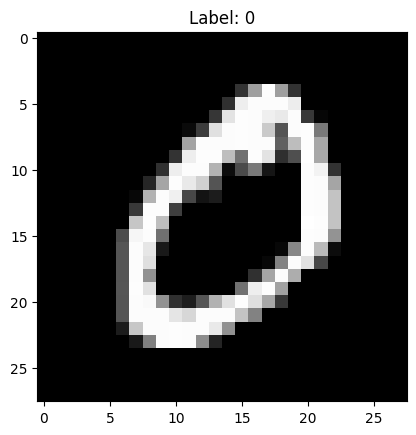

Label: 1


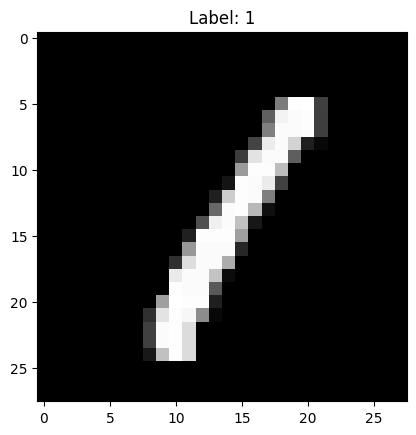

In [28]:
def display_image_and_tensor(dataset, index):
    image, label = dataset[index]  # Get the first image and its label
    
    print("Label:", label)
    image_np = image.squeeze().numpy()  

    plt.imshow(image_np, cmap='gray')
    plt.title(f'Label: {label}')
    plt.show()

display_image_and_tensor(full_dataset, 1)
display_image_and_tensor(filtered_dataset, 1)

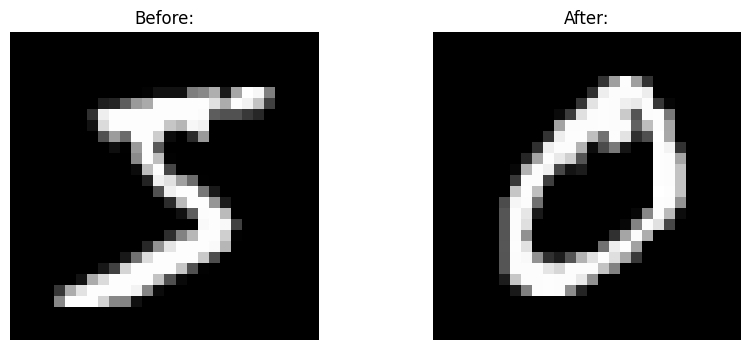

In [29]:
def plot_two_tensors(tensor1, tensor2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Create a figure with two subplots

    axes[0].imshow(tensor1.squeeze(), cmap='gray')  # Remove channel dimension if exists and plot
    axes[0].set_title(f'Before:')
    axes[0].axis('off')  # Hide axes ticks

    axes[1].imshow(tensor2.squeeze(), cmap='gray')
    axes[1].set_title(f'After:')
    axes[1].axis('off')

    plt.show()
plot_two_tensors(full_dataset[0][0], full_dataset[1][0])  

In [30]:

def get_dataloaders(dataset, train_ratio, val_ratio, batch_size, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    train_dataset = dataset
    val_dataset = dataset
    test_dataset = dataset
    # obtain training indices that will be used for validation
    num_train = len(test_dataset)
    indices = list(range(num_train))
    print("--------- INDEX checking ---------")
    print(f"Original: {indices[:5]}")
    random.shuffle(indices)
    print(f"Shuffled: {indices[:5]}")
    print("--------- INDEX shuffled ---------\n")

    split_train = int(np.floor(train_ratio * num_train))
    split_val = split_train + int(np.floor(val_ratio * (num_train-split_train)))
    train_idx, val_idx, test_idx = indices[0:split_train], indices[split_train:split_val], indices[split_val:]
    merge_dataset = Subset(train_dataset, train_idx)

    train_loader = DataLoader(merge_dataset, batch_size=batch_size)
    val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=batch_size)
    test_loader = DataLoader(Subset(test_dataset, test_idx), batch_size=batch_size)
    
    # check dataset
    print(f"Total number of samples: {num_train} datapoints")
    print(f"Number of train samples: {len(train_loader)} batches/ {len(train_loader.dataset)} datapoints")
    print(f"Number of val samples: {len(val_loader)} batches/ {len(val_loader.dataset)} datapoints")
    print(f"Number of test samples: {len(test_loader)} batches/ {len(test_loader.dataset)} datapoints")
    print(f"")
    
    dataloaders = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
    }
    return dataloaders
dataloaders = get_dataloaders(filtered_dataset, 0.8, 1, 64, 6452916)
full_dataloaders = get_dataloaders(full_dataset, 0.8, 1, 64, 6452916)


--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [12235, 16413, 3163, 5348, 21316]
--------- INDEX shuffled ---------

Total number of samples: 24559 datapoints
Number of train samples: 307 batches/ 19647 datapoints
Number of val samples: 77 batches/ 4912 datapoints
Number of test samples: 0 batches/ 0 datapoints

--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [56774, 32710, 56427, 49406, 20372]
--------- INDEX shuffled ---------

Total number of samples: 60000 datapoints
Number of train samples: 750 batches/ 48000 datapoints
Number of val samples: 188 batches/ 12000 datapoints
Number of test samples: 0 batches/ 0 datapoints



In [31]:
def count_parameters(model):
    total_num = 0

    for parameter in model.parameters():
        if parameter.requires_grad:
            total_num += parameter.numel() 
    return total_num

## 1. Image Classifier

In [32]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # Output: 16 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                # Output: 16 x 14 x 14
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),# Output: 32 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_net = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, len([1, 3, 5, 7]))
        )

    def forward(self, x):
        x = self.conv_net(x)
        x = x.view(x.size(0), -1)
        x = self.fc_net(x)
        return x


### Train image classifier

In [33]:
label_mapping = {1: 0, 3: 1, 5: 2, 7: 3}

def transform_labels(labels):
    transformed_labels = torch.tensor([label_mapping[label.item()] for label in labels])
    return transformed_labels


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DigitClassifier().to(device)
print(f"Model: DigitClassifier")
model_parameters_amount = count_parameters(model)
print(f"model total parameters: {model_parameters_amount:,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
epochs = 1

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0
    for images, labels in tqdm(dataloaders['train']):
        labels = transform_labels(labels)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}\n[TRAIN] Accuracy: {100 * correct / total:.2f}%, Loss: {running_loss / total}')

    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(dataloaders['val']):
            labels = transform_labels(labels)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    print(f'[VALID] Accuracy: {100 * correct / total:.2f}%, Loss: {running_loss / total}\n')


Model: DigitClassifier
model total parameters: 206,148


  0%|          | 0/307 [00:01<?, ?it/s]


KeyboardInterrupt: 

### Abnormal Detection

In [ ]:

normal_labels = torch.tensor([1, 3, 5, 7], device=device)
best_acc = 0
best_anomaly_threshold = 0
segment_size = 2
for ii in range(segment_size):
    anomaly_threshold = ii / float(segment_size)

    model.eval()
    total, correct = 0, 0
    anomalies = []
    with torch.no_grad():
        for images, labels in tqdm(full_dataloaders['val']):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            max_probs, predictions = torch.max(probabilities, dim=1)
            anomaly_mask = max_probs > anomaly_threshold

            # Check if each label in the batch is from the trained set (1, 3, 5, 7)
            is_normal = torch.isin(labels, normal_labels)

            correct_preds = (is_normal & ~anomaly_mask) | (~is_normal & anomaly_mask)
            correct += correct_preds.sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    if accuracy > best_acc:
        best_acc = accuracy
        best_anomaly_threshold = anomaly_threshold
    print(f'Anomaly detection accuracy: {accuracy:.2f}% \nAnomaly_threshold: {anomaly_threshold}\n')

print(f'Anomaly detection accuracy: {best_acc:.2f}% \nAnomaly_threshold: {best_anomaly_threshold}')

100%|██████████| 188/188 [00:01<00:00, 167.91it/s]


Anomaly detection accuracy: 57.96% 
Anomaly_threshold: 0.0



100%|██████████| 188/188 [00:01<00:00, 167.91it/s]

Anomaly detection accuracy: 56.97% 
Anomaly_threshold: 0.5

Anomaly detection accuracy: 57.96% 
Anomaly_threshold: 0.0


## 2. Normal Autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
        )
        self.decoder = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Sigmoid activation to output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### Train normal autoencoder

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
print(f"Model: Autoencoder")
model_parameters_amount = count_parameters(model)
print(f"model total parameters: {model_parameters_amount:,}")

# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0
    for images, _ in tqdm(dataloaders['train']):
        images = images.to(device)
        images = images.view(images.size(0), -1)
        # images.requires_grad_()

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += images.size(0)
        running_loss += loss.item()


    print(f'Epoch {epoch+1}\n[TRAIN] Loss: {running_loss / total}')

    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for images, _ in tqdm(dataloaders['val']):
            images = images.to(device)
            images = images.view(images.size(0), -1)
            # images.requires_grad_()
            
            outputs = model(images)
            loss = criterion(outputs, images)
            total += images.size(0)
            running_loss += loss.item()

    print(f'[VALID] Loss: {running_loss / total}\n')


Model: Autoencoder
model total parameters: 219,804


100%|██████████| 307/307 [00:02<00:00, 137.10it/s]


Epoch 1
[TRAIN] Loss: 0.01524902626643771


100%|██████████| 77/77 [00:00<00:00, 187.87it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 135.89it/s]


Epoch 2
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 183.40it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 132.94it/s]


Epoch 3
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 183.40it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 134.69it/s]


Epoch 4
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 187.87it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 134.11it/s]


Epoch 5
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 187.87it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 135.29it/s]


Epoch 6
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 187.87it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 134.11it/s]


Epoch 7
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 183.38it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 134.11it/s]


Epoch 8
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 183.39it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 133.52it/s]


Epoch 9
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 187.87it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 135.29it/s]


Epoch 10
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 187.87it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 134.11it/s]


Epoch 11
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 183.40it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 131.80it/s]


Epoch 12
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 183.39it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 131.24it/s]


Epoch 13
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 179.13it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 127.96it/s]


Epoch 14
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 183.39it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 132.94it/s]


Epoch 15
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 183.39it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 128.50it/s]


Epoch 16
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 175.06it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 131.24it/s]


Epoch 17
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 183.41it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 128.49it/s]


Epoch 18
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 179.11it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 131.80it/s]


Epoch 19
[TRAIN] Loss: 0.014590421875554526


100%|██████████| 77/77 [00:00<00:00, 183.38it/s]


[VALID] Loss: 0.014633682705097944



100%|██████████| 307/307 [00:02<00:00, 132.37it/s]


Epoch 20
[TRAIN] Loss: 0.014590421435656654


100%|██████████| 77/77 [00:00<00:00, 183.39it/s]

[VALID] Loss: 0.014633682705097944



### Result Visualization

64
torch.Size([64, 784])


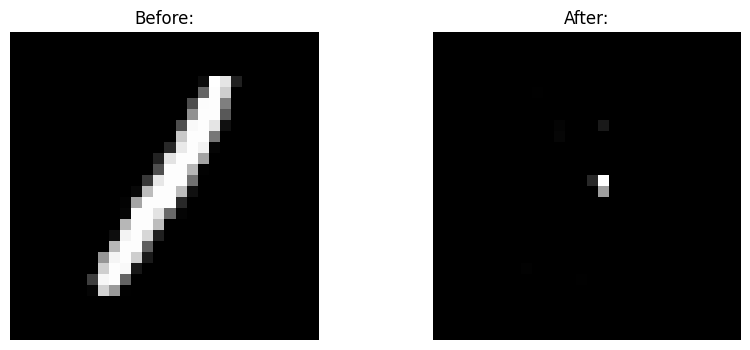

In [ ]:
index = 63
with torch.no_grad():
    for images, _ in dataloaders['val']:
        images = images.to(device)
        images = images.view(images.size(0), -1)
        
        outputs = model(images)
        print(len(outputs))
        print(outputs.shape)
        plot_two_tensors(images[index].cpu().view(28,28), outputs[index].cpu().view(28,28))
        break


### abnormal detection

In [ ]:
best_acc = 0
best_anomaly_threshold = 0

criterion = torch.nn.MSELoss(reduction='none')
# criterion = torch.nn.MSELoss()

segment_size = 20
for ii in range(segment_size):
    anomaly_threshold = ii / float(segment_size)

    model.eval()
    total, correct = 0, 0
    losses = []
    with torch.no_grad():
        for images, labels in full_dataloaders['val']:
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(images.size(0), -1)

            outputs = model(images)

            # Calculate loss per image (mean across each image's feature dimension)
            loss = criterion(outputs, images).mean(dim=1)  # Get per image loss
            
            anomaly_mask = loss > anomaly_threshold

            is_normal = torch.isin(labels, normal_labels)

            correct_preds = (~is_normal & anomaly_mask) | (is_normal & ~anomaly_mask)
            correct += correct_preds.sum().item()
            total += labels.size(0)
            
        accuracy = 100 * correct / total
        if accuracy > best_acc:
            best_acc = accuracy
            best_anomaly_threshold = anomaly_threshold
        print(f'Anomaly detection accuracy: {accuracy:.2f}% at threshold: {anomaly_threshold}')

print(f'Best anomaly detection accuracy: {best_acc:.2f}% at threshold: {best_anomaly_threshold}')


Anomaly detection accuracy: 57.96% at threshold: 0.0
Anomaly detection accuracy: 57.96% at threshold: 0.05
Anomaly detection accuracy: 57.96% at threshold: 0.1
Anomaly detection accuracy: 57.96% at threshold: 0.15
Anomaly detection accuracy: 57.96% at threshold: 0.2
Anomaly detection accuracy: 57.96% at threshold: 0.25
Anomaly detection accuracy: 57.96% at threshold: 0.3
Anomaly detection accuracy: 57.96% at threshold: 0.35
Anomaly detection accuracy: 57.96% at threshold: 0.4
Anomaly detection accuracy: 57.96% at threshold: 0.45
Anomaly detection accuracy: 57.96% at threshold: 0.5
Anomaly detection accuracy: 57.96% at threshold: 0.55
Anomaly detection accuracy: 57.96% at threshold: 0.6
Anomaly detection accuracy: 57.96% at threshold: 0.65
Anomaly detection accuracy: 57.96% at threshold: 0.7
Anomaly detection accuracy: 57.96% at threshold: 0.75
Anomaly detection accuracy: 57.96% at threshold: 0.8
Anomaly detection accuracy: 57.96% at threshold: 0.85
Anomaly detection accuracy: 55.02% at

## 3. Denoising Autoencoder

In [ ]:
class Denoise_Autoencoder(nn.Module):
    def __init__(self):
        super(Denoise_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
        )
        self.decoder = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Sigmoid activation to output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### Train Denoising Autoencoder

In [ ]:
def add_noise(imgs, noise_factor=0.5):
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
    noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
    return noisy_imgs

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Denoise_Autoencoder().to(device)
print(f"Model: Denoise_Autoencoder")
model_parameters_amount = count_parameters(model)
print(f"model total parameters: {model_parameters_amount:,}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0
    for images, _ in tqdm(dataloaders['train']):
        images = images.to(device)
        noisy_images = add_noise(images)

        images = images.view(images.size(0), -1)
        noisy_images = noisy_images.view(noisy_images.size(0), -1)

        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total += images.size(0)
        running_loss += loss.item()


    print(f'Epoch {epoch+1}\n[TRAIN] Loss: {running_loss / total}')

    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for images, _ in tqdm(dataloaders['val']):
            images = images.to(device)
            noisy_images = add_noise(images)
            images = images.view(images.size(0), -1)
            noisy_images = noisy_images.view(images.size(0), -1)
            
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            total += images.size(0)
            running_loss += loss.item()

    print(f'[VALID] Loss: {running_loss / total}\n')



Model: Denoise_Autoencoder
model total parameters: 219,804


100%|██████████| 307/307 [00:02<00:00, 134.11it/s]


Epoch 1
[TRAIN] Loss: 0.015605006490025792


100%|██████████| 77/77 [00:00<00:00, 179.11it/s]


[VALID] Loss: 0.01463321721369358



100%|██████████| 307/307 [00:02<00:00, 134.69it/s]


Epoch 2
[TRAIN] Loss: 0.014589000419908524


100%|██████████| 77/77 [00:00<00:00, 183.40it/s]


[VALID] Loss: 0.014627362416407962



100%|██████████| 307/307 [00:02<00:00, 132.94it/s]


Epoch 3
[TRAIN] Loss: 0.014582626800315765


100%|██████████| 77/77 [00:00<00:00, 183.42it/s]


[VALID] Loss: 0.01462507122939495



100%|██████████| 307/307 [00:02<00:00, 132.37it/s]


Epoch 4
[TRAIN] Loss: 0.014576504131840792


100%|██████████| 77/77 [00:00<00:00, 179.13it/s]


[VALID] Loss: 0.01461797724523451



100%|██████████| 307/307 [00:02<00:00, 132.37it/s]


Epoch 5
[TRAIN] Loss: 0.014574568323332548


100%|██████████| 77/77 [00:00<00:00, 183.40it/s]


[VALID] Loss: 0.014617373517650734



100%|██████████| 307/307 [00:02<00:00, 132.37it/s]


Epoch 6
[TRAIN] Loss: 0.014569943470706611


100%|██████████| 77/77 [00:00<00:00, 179.13it/s]


[VALID] Loss: 0.014609281507590695



100%|██████████| 307/307 [00:02<00:00, 130.13it/s]


Epoch 7
[TRAIN] Loss: 0.014565554203110724


100%|██████████| 77/77 [00:00<00:00, 179.13it/s]


[VALID] Loss: 0.014608634848159765



100%|██████████| 307/307 [00:02<00:00, 132.37it/s]


Epoch 8
[TRAIN] Loss: 0.014565073437209456


100%|██████████| 77/77 [00:00<00:00, 183.39it/s]


[VALID] Loss: 0.014608074974644844



100%|██████████| 307/307 [00:02<00:00, 131.24it/s]


Epoch 9
[TRAIN] Loss: 0.014563034550011561


100%|██████████| 77/77 [00:00<00:00, 183.44it/s]


[VALID] Loss: 0.014604828402351479



100%|██████████| 307/307 [00:02<00:00, 132.94it/s]


Epoch 10
[TRAIN] Loss: 0.014561366651442515


100%|██████████| 77/77 [00:00<00:00, 183.39it/s]


[VALID] Loss: 0.014604558421948056



100%|██████████| 307/307 [00:02<00:00, 131.80it/s]


Epoch 11
[TRAIN] Loss: 0.014561131466871218


100%|██████████| 77/77 [00:00<00:00, 175.06it/s]


[VALID] Loss: 0.014604212940709987



100%|██████████| 307/307 [00:02<00:00, 131.24it/s]


Epoch 12
[TRAIN] Loss: 0.014551357891794172


100%|██████████| 77/77 [00:00<00:00, 183.40it/s]


[VALID] Loss: 0.014588254464468662



100%|██████████| 307/307 [00:02<00:00, 133.52it/s]


Epoch 13
[TRAIN] Loss: 0.014532082343687627


100%|██████████| 77/77 [00:00<00:00, 183.39it/s]


[VALID] Loss: 0.014547040461523136



100%|██████████| 307/307 [00:02<00:00, 134.11it/s]


Epoch 14
[TRAIN] Loss: 0.014462813983019625


100%|██████████| 77/77 [00:00<00:00, 187.87it/s]


[VALID] Loss: 0.014484296634744744



100%|██████████| 307/307 [00:02<00:00, 133.53it/s]


Epoch 15
[TRAIN] Loss: 0.014435312202117908


100%|██████████| 77/77 [00:00<00:00, 183.38it/s]


[VALID] Loss: 0.01446522528408793



100%|██████████| 307/307 [00:02<00:00, 135.29it/s]


Epoch 16
[TRAIN] Loss: 0.01440462237212132


100%|██████████| 77/77 [00:00<00:00, 183.40it/s]


[VALID] Loss: 0.014429672314794521



100%|██████████| 307/307 [00:02<00:00, 133.52it/s]


Epoch 17
[TRAIN] Loss: 0.014371461402176416


100%|██████████| 77/77 [00:00<00:00, 183.39it/s]


[VALID] Loss: 0.014401374876207948



100%|██████████| 307/307 [00:02<00:00, 133.52it/s]


Epoch 18
[TRAIN] Loss: 0.01435110284371152


100%|██████████| 77/77 [00:00<00:00, 183.39it/s]


[VALID] Loss: 0.014386484417639648



100%|██████████| 307/307 [00:02<00:00, 132.95it/s]


Epoch 19
[TRAIN] Loss: 0.014335985622885586


100%|██████████| 77/77 [00:00<00:00, 179.13it/s]


[VALID] Loss: 0.014371770625199868



100%|██████████| 307/307 [00:02<00:00, 133.52it/s]


Epoch 20
[TRAIN] Loss: 0.014325008948364895


100%|██████████| 77/77 [00:00<00:00, 183.39it/s]

[VALID] Loss: 0.014364577016826561



### Result Visualization

In [ ]:
def plot_three_tensors(tensor1, tensor2, tensor3):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))  # Create a figure with two subplots

    axes[0].imshow(tensor1.squeeze(), cmap='gray')  # Remove channel dimension if exists and plot
    axes[0].set_title(f'Before:')
    axes[0].axis('off')  # Hide axes ticks

    axes[1].imshow(tensor2.squeeze(), cmap='gray')
    axes[1].set_title(f'Add Noise:')
    axes[1].axis('off')

    axes[2].imshow(tensor3.squeeze(), cmap='gray')
    axes[2].set_title(f'After:')
    axes[2].axis('off')
    plt.show()

Label: 1
torch.Size([64, 784])


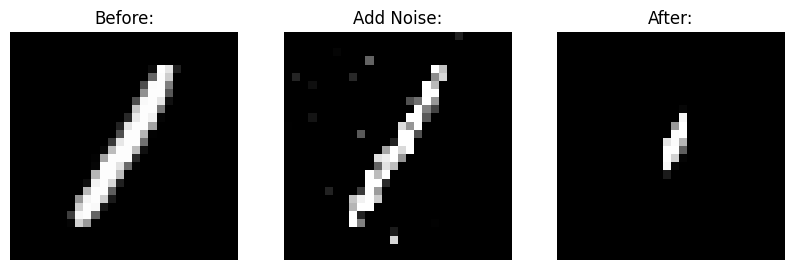

In [ ]:
index = 63
with torch.no_grad():
    for images, label in dataloaders['val']:
        images = images.to(device)
        noisy_images = add_noise(images)
        images = images.view(images.size(0), -1)
        noisy_images = noisy_images.view(noisy_images.size(0), -1)
        
        outputs = model(noisy_images)
        print("Label:", label[index].item())
        print(outputs.shape)
        plot_three_tensors(images[index].cpu().view(28,28), noisy_images[index].cpu().view(28,28), outputs[index].cpu().view(28,28))
        break

### abnormal detection

In [ ]:
best_acc = 0
best_anomaly_threshold = 0

criterion = torch.nn.MSELoss(reduction='none')

segment_size = 20
for ii in range(segment_size):
    anomaly_threshold = ii / float(segment_size)

    model.eval()
    total, correct = 0, 0
    losses = []
    with torch.no_grad():
        for images, labels in full_dataloaders['val']:
            images = images.to(device)
            noisy_images = add_noise(images)
            labels = labels.to(device)
            
            images = images.view(images.size(0), -1)
            noisy_images = noisy_images.view(noisy_images.size(0), -1)

            outputs = model(noisy_images)

            # Calculate loss per image (mean across each image's feature dimension)
            loss = criterion(outputs, images).mean(dim=1)  # Get per image loss
            
            anomaly_mask = loss > anomaly_threshold

            is_normal = torch.isin(labels, normal_labels)

            correct_preds = (~is_normal & anomaly_mask) | (is_normal & ~anomaly_mask)
            correct += correct_preds.sum().item()
            total += labels.size(0)
            
        accuracy = 100 * correct / total
        if accuracy > best_acc:
            best_acc = accuracy
            best_anomaly_threshold = anomaly_threshold
        print(f'Anomaly detection accuracy: {accuracy:.2f}% at threshold: {anomaly_threshold}')

print(f'Best anomaly detection accuracy: {best_acc:.2f}% at threshold: {best_anomaly_threshold}')


Anomaly detection accuracy: 57.96% at threshold: 0.0
Anomaly detection accuracy: 57.96% at threshold: 0.05
Anomaly detection accuracy: 57.96% at threshold: 0.1
Anomaly detection accuracy: 57.96% at threshold: 0.15
Anomaly detection accuracy: 57.96% at threshold: 0.2
Anomaly detection accuracy: 57.96% at threshold: 0.25
Anomaly detection accuracy: 57.96% at threshold: 0.3
Anomaly detection accuracy: 57.96% at threshold: 0.35
Anomaly detection accuracy: 57.96% at threshold: 0.4
Anomaly detection accuracy: 57.96% at threshold: 0.45
Anomaly detection accuracy: 57.96% at threshold: 0.5
Anomaly detection accuracy: 57.96% at threshold: 0.55
Anomaly detection accuracy: 57.96% at threshold: 0.6
Anomaly detection accuracy: 57.96% at threshold: 0.65
Anomaly detection accuracy: 57.96% at threshold: 0.7
Anomaly detection accuracy: 57.96% at threshold: 0.75
Anomaly detection accuracy: 57.96% at threshold: 0.8
Anomaly detection accuracy: 57.97% at threshold: 0.85
Anomaly detection accuracy: 49.30% at

## 4. Variational autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc_mean = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, input_dim)
    
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mean(h1), self.fc_logvar(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h2 = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))  # Assuming input is 28x28 (for MNIST)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


### Train VAE

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    assert torch.max(recon_x) <= 1 and torch.min(recon_x) >= 0, "Recon_x out of bounds"
    assert torch.max(x) <= 1 and torch.min(x) >= 0, "x out of bounds"
    
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KL


In [38]:
device = 'cuda'
latent_dim = 20  # Latent dimensionality
input_dim = 784  # 28x28 images flattened
model = VAE(input_dim,latent_dim).to(device)
print(f"Model: VAE")
model_parameters_amount = count_parameters(model)
print(f"model total parameters: {model_parameters_amount:,}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 1

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0
    for images, _ in tqdm(dataloaders['train']):
        images = images.to(device)
        images = images.view(images.size(0), -1)

        recon_batch, mu, logvar = model(images)
        loss = vae_loss(recon_batch, images, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total += images.size(0)
        running_loss += loss.item()


    print(f'Epoch {epoch+1}\n[TRAIN] Loss: {running_loss / total}')

    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for images, _ in tqdm(dataloaders['val']):
            images = images.to(device)
            images = images.view(images.size(0), -1)
            
            recon_batch, mu, logvar = model(images)
            loss = vae_loss(recon_batch, images, mu, logvar)
            total += images.size(0)
            running_loss += loss.item()

    print(f'[VALID] Loss: {running_loss / total}\n')

Model: VAE
model total parameters: 652,824


100%|██████████| 307/307 [00:01<00:00, 198.13it/s]


Epoch 1
[TRAIN] Loss: 159.85039641071157


100%|██████████| 77/77 [00:00<00:00, 308.10it/s]

[VALID] Loss: 123.94095107087871



### Result Visualization

torch.Size([64, 784])


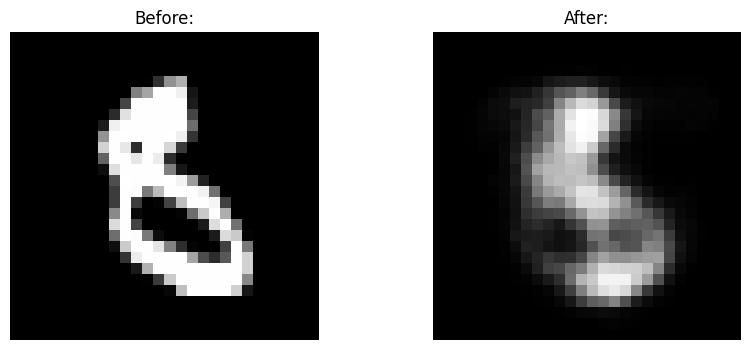

In [55]:
index = 1

with torch.no_grad():
    for images, _ in full_dataloaders['val']:
        images = images.to(device)
        images = images.view(images.size(0), -1)
        
        recon_batch, mu, logvar = model(images)
        print(recon_batch.shape)
        plot_two_tensors(images[index].cpu().view(28,28), recon_batch[index].cpu().view(28,28))
        break


### abnormal detection

In [60]:
best_acc = 0
best_anomaly_threshold = 0
normal_labels = torch.tensor([1, 3, 5, 7], device=device)

segment_size = 10 
for ii in range(segment_size):
    anomaly_threshold = ii / float(segment_size) * 10000 + 1000

    model.eval()
    total, correct = 0, 0
    losses = []
    with torch.no_grad():
        for images, labels in full_dataloaders['val']:
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(images.size(0), -1)

            recon_batch, mu, logvar = model(images)

            # Calculate loss per image (mean across each image's feature dimension)
            loss = vae_loss(recon_batch, images, mu, logvar)
            anomaly_mask = loss > anomaly_threshold

            is_normal = torch.isin(labels, normal_labels)

            correct_preds = (~is_normal & anomaly_mask) | (is_normal & ~anomaly_mask)
            correct += correct_preds.sum().item()
            total += labels.size(0)

        accuracy = 100 * correct / total
        if accuracy > best_acc:
            best_acc = accuracy
            best_anomaly_threshold = anomaly_threshold
        print(f'Anomaly detection accuracy: {accuracy:.2f}% at threshold: {anomaly_threshold}')

print(f'Best anomaly detection accuracy: {best_acc:.2f}% at threshold: {best_anomaly_threshold}')


Anomaly detection accuracy: 57.96% at threshold: 1000.0
Anomaly detection accuracy: 57.96% at threshold: 2000.0
Anomaly detection accuracy: 57.96% at threshold: 3000.0
Anomaly detection accuracy: 57.96% at threshold: 4000.0
Anomaly detection accuracy: 57.96% at threshold: 5000.0
Anomaly detection accuracy: 57.96% at threshold: 6000.0
Anomaly detection accuracy: 57.96% at threshold: 7000.0
Anomaly detection accuracy: 57.96% at threshold: 8000.0
Anomaly detection accuracy: 57.96% at threshold: 9000.0
Anomaly detection accuracy: 57.79% at threshold: 10000.0
Best anomaly detection accuracy: 57.96% at threshold: 1000.0


## 5. Isolated Forrest

In [66]:

from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data  # Feature matrix where each row is a flattened image

# Initialize Isolation Forest
clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.1), random_state=42)

# Fit the model
clf.fit(X)

# Predictions on the training data
y_pred_train = clf.predict(X)

# -1 for outliers and 1 for inliers.
outliers = X[y_pred_train == -1]

from sklearn.metrics import classification_report

# Assume we have some labels indicating 1 for normal and -1 for anomalies
true_labels = np.full(X.shape[0], 1)
true_labels[::10] = -1  # Example: mark every 10th sample as an outlier

print(classification_report(true_labels, y_pred_train))




              precision    recall  f1-score   support

          -1       0.06      0.06      0.06       180
           1       0.90      0.90      0.90      1617

    accuracy                           0.81      1797
   macro avg       0.48      0.48      0.48      1797
weighted avg       0.81      0.81      0.81      1797



### Train image classifier

### abnormal detection

## 6. Isolated Forrest with pre-trained feature extractor.

### Train image classifier

### abnormal detection

## 7. Comparison and Conclusion